In [2]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import torch

import matplotlib.pyplot as plt

from dlp.dataset import Dataset

from parksim.intent_predict.cnnV2.data_processing.utils import CNNDataProcessor
from parksim.trajectory_predict.data_processing.utils import TransformerDataProcessor

from parksim.intent_predict.cnnV2.network import SmallRegularizedCNN
from parksim.trajectory_predict.intent_transformer.network import TrajectoryPredictorWithIntent
from parksim.trajectory_predict.intent_transformer.train import build_trajectory_predict_from_config

from parksim.trajectory_predict.intent_transformer.multimodal_prediction import predict_multimodal

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
ds = Dataset()

home_path = str(Path.home())
ds.load(home_path + '/dlp-dataset/data/DJI_0012')

In [4]:
MODEL_PATH = 'models/Trajectory-Intent-4-10-22.pth'
# MODEL_PATH = 'models/checkpoint.pt'
config = {
    'dim_model': 52,
    'num_heads': 4,
    'dropout': 0.15,
    'num_encoder_layers': 16,
    'num_decoder_layers': 8,
    'd_hidden': 256,
    'num_conv_layers': 2,
    'opt': 'SGD',
    'lr': 0.0025,
    'loss': 'L1'
}

traj_model = build_trajectory_predict_from_config(config=config)
model_state = torch.load(MODEL_PATH, map_location=DEVICE)
traj_model.load_state_dict(model_state)
traj_model.eval().to(DEVICE)

INTENT_MODEL_PATH = 'models/smallRegularizedCNN_L0.068_01-29-2022_19-50-35.pth'
intent_model = SmallRegularizedCNN()
model_state = torch.load(INTENT_MODEL_PATH, map_location=DEVICE)
intent_model.load_state_dict(model_state)
intent_model.eval().to(DEVICE)

SmallRegularizedCNN(
  (image_layer): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 8, kernel_size=(7, 7), stride=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.2, inplace=False)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.2, inplace=False)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.2, inplace=False)
      (3): LeakyReLU(

In [5]:
intent_extractor = CNNDataProcessor(ds=ds)
traj_extractor = TransformerDataProcessor(ds=ds)

In [6]:
def draw_prediction(multimodal_prediction, inst_centric_view, colors, intent_offsets):
    sensing_limit = 20
    img_size = inst_centric_view.size[0] / 2

    plt.cla()

    plt.imshow(inst_centric_view)

    y_label, _, _, _ = multimodal_prediction[0]

    traj_future_pixel = y_label[0, :, :2].detach().cpu().numpy() / \
        sensing_limit*img_size + img_size

    plt.plot(traj_future_pixel[:, 0], traj_future_pixel[:, 1], 'wo', linewidth=2, markersize=2)

    for prediction, color, offset in zip(reversed(multimodal_prediction), reversed(colors), reversed(intent_offsets)):

        _, pred, intent, probability = prediction

        intent_pixel = intent[0, 0, :2].detach().cpu().numpy() / \
            sensing_limit*img_size + img_size

        traj_pred_pixel = pred[0, :, :2].detach().cpu().numpy() / \
            sensing_limit*img_size + img_size

        plt.plot(traj_pred_pixel[:, 0], traj_pred_pixel[:, 1],
                 '^', color=color, linewidth=2, markersize=2)
        plt.plot(intent_pixel[0], intent_pixel[1],
                 '*', color=color, markersize=8)

        plt.text(intent_pixel[0]+offset[0], intent_pixel[1]+offset[1],
                 f'{probability:.2f}', backgroundcolor=(170/255., 170/255., 170/255., 0.53), color='black', size=7, weight='bold')
        print(color, probability)
                 
    plt.axis('off')


# Example 1

In [7]:
scene = ds.get('scene', ds.list_scenes()[0])
frame_index = 80
frame = ds.get_future_frames(scene['first_frame'],timesteps=300)[frame_index]
inst_token = frame['instances'][1]

In [8]:
multimodal_prediction, inst_centric_view = predict_multimodal(
    ds, traj_model, intent_model, traj_extractor, intent_extractor, inst_token, frame_index, 3)


1.272362470626831
1.272362470626831
1.272362470626831


green 0.12416925032933553
C1 0.22350465059280394
darkviolet 0.5509031


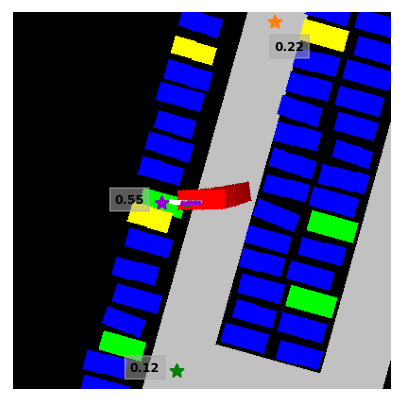

In [60]:
colors = ['darkviolet', 'C1', 'green']
intent_offsets = [[-50,0], [0,30], [-50,0]]

draw_prediction(multimodal_prediction, inst_centric_view,
                colors, intent_offsets)


# Example 2

In [9]:
scene = ds.get('scene', ds.list_scenes()[0])
frame_index = 2500
frame = ds.get_future_frames(scene['first_frame'], timesteps=2700)[frame_index]
inst_token = frame['instances'][33]


In [10]:
multimodal_prediction, inst_centric_view = predict_multimodal(
    ds, traj_model, intent_model, traj_extractor, intent_extractor, inst_token, frame_index, 3)


2.657642126083374
2.657642126083374
2.657642126083374


green 0.13618726
C1 0.1741322
darkviolet 0.2132135


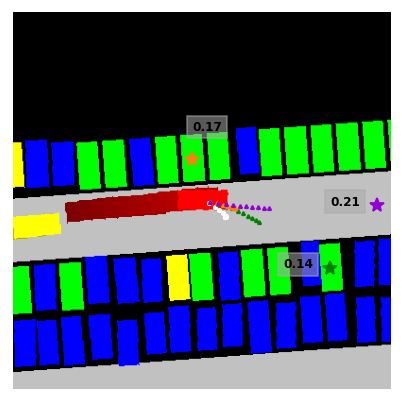

In [11]:
colors = ['darkviolet', 'C1', 'green']
intent_offsets = [[-50, 0], [0, -30], [-50, 0]]

draw_prediction(multimodal_prediction, inst_centric_view,
                colors, intent_offsets)


# Example 3

In [15]:
scene = ds.get('scene', ds.list_scenes()[0])
frame_index = 5900
frame = ds.get_future_frames(scene['first_frame'], timesteps=6000)[frame_index]
inst_token = frame['instances'][37]


In [16]:
multimodal_prediction, inst_centric_view = predict_multimodal(
    ds, traj_model, intent_model, traj_extractor, intent_extractor, inst_token, frame_index, 3)


2.7500102519989014
2.7500102519989014
2.7500102519989014


green 0.10004302
C1 0.11806252598762512
darkviolet 0.17507713


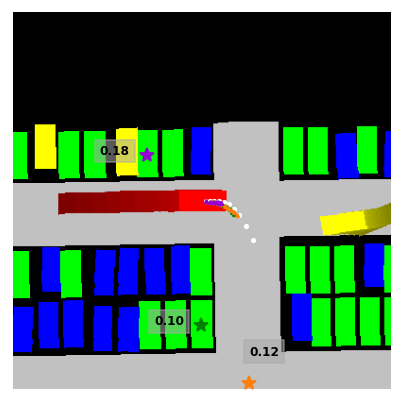

In [57]:
colors = ['darkviolet', 'C1', 'green']
intent_offsets = [[-50, 0], [0, -30], [-50, 0]]

draw_prediction(multimodal_prediction, inst_centric_view,
                colors, intent_offsets)


# Example 4

In [15]:
scene = ds.get('scene', ds.list_scenes()[0])
frame_index = 4000
frame = ds.get_future_frames(scene['first_frame'], timesteps=6000)[frame_index]
inst_token = frame['instances'][36]


In [16]:
multimodal_prediction, inst_centric_view = predict_multimodal(
    ds, traj_model, intent_model, traj_extractor, intent_extractor, inst_token, frame_index, 3)


green 0.16416848
C1 0.1965143
darkviolet 0.22249979


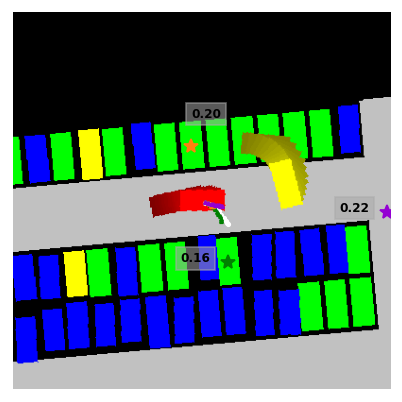

In [17]:
colors = ['darkviolet', 'C1', 'green']
intent_offsets = [[-50, 0], [0, -30], [-50, 0]]

draw_prediction(multimodal_prediction, inst_centric_view,
                colors, intent_offsets)


# Example 5

In [11]:
scene = ds.get('scene', ds.list_scenes()[0])
frame_index = 100
frame = ds.get_future_frames(scene['first_frame'], timesteps=6000)[frame_index]
inst_token = frame['instances'][6]


In [12]:
multimodal_prediction, inst_centric_view = predict_multimodal(
    ds, traj_model, intent_model, traj_extractor, intent_extractor, inst_token, frame_index, 3)


1.365386724472046
1.365386724472046
1.365386724472046


green 0.06666666666666667
C1 0.3333333333333333
darkviolet 0.6


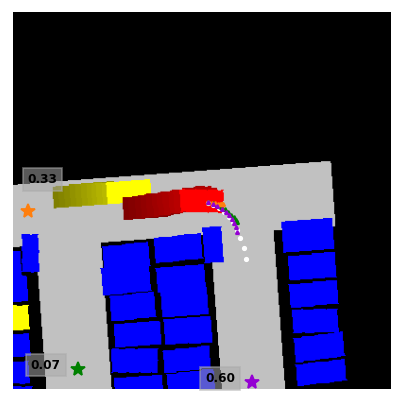

In [114]:
colors = ['darkviolet', 'C1', 'green']
intent_offsets = [[-50, 0], [0, -30], [-50, 0]]

draw_prediction(multimodal_prediction, inst_centric_view,
                colors, intent_offsets)


# Example 6

In [13]:
scene = ds.get('scene', ds.list_scenes()[0])
frame_index = 1800
frame = ds.get_future_frames(scene['first_frame'], timesteps=6000)[frame_index]
# inst_token = frame['instances'][6]
inst_token = ds.get_inst_at_location(frame_token=frame['frame_token'], coords=[70, 30])[
    'instance_token']


In [14]:
multimodal_prediction, inst_centric_view = predict_multimodal(
    ds, traj_model, intent_model, traj_extractor, intent_extractor, inst_token, frame_index, 3)


1.6769801378250122
1.6769801378250122
1.6769801378250122


green 0.14741127
C1 0.19268673062324523
darkviolet 0.2888196


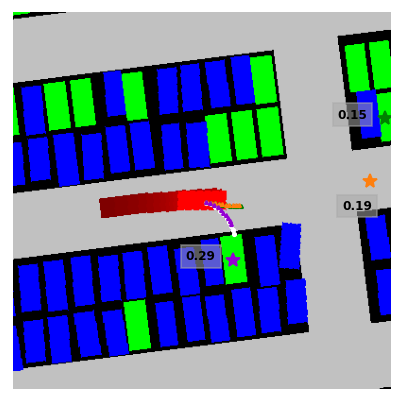

In [65]:
colors = ['darkviolet', 'C1', 'green']
intent_offsets = [[-50, 0], [-30, 30], [-50, 0]]

draw_prediction(multimodal_prediction, inst_centric_view,
                colors, intent_offsets)


# Example 7

In [66]:
scene = ds.get('scene', ds.list_scenes()[0])
frame_index = 7010
frame = ds.get_future_frames(scene['first_frame'], timesteps=7100)[frame_index]
# inst_token = frame['instances'][6]
inst_token = ds.get_inst_at_location(frame_token=frame['frame_token'], coords=[15, 30])[
    'instance_token']


In [67]:
multimodal_prediction, inst_centric_view = predict_multimodal(
    ds, traj_model, intent_model, traj_extractor, intent_extractor, inst_token, frame_index, 3)


green 0.09657282630602518
C1 0.17383108735084532
darkviolet 0.70884466


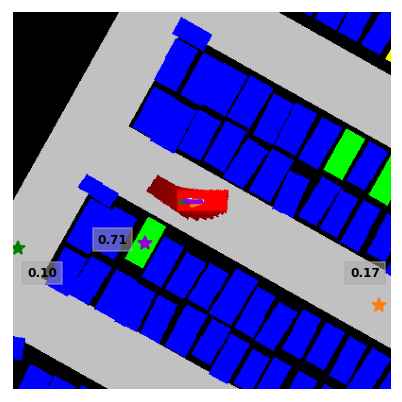

In [70]:
colors = ['darkviolet', 'C1', 'green']
intent_offsets = [[-50, 0], [-30, -30], [10, 30]]

draw_prediction(multimodal_prediction, inst_centric_view,
                colors, intent_offsets)


# Example 8

In [105]:
scene = ds.get('scene', ds.list_scenes()[0])
frame_index = 9000
frame = ds.get_future_frames(scene['first_frame'], timesteps=9001)[frame_index]
# inst_token = frame['instances'][6]
inst_token = ds.get_inst_at_location(frame_token=frame['frame_token'], coords=[35, 65])[
    'instance_token']


In [106]:
multimodal_prediction, inst_centric_view = predict_multimodal(
    ds, traj_model, intent_model, traj_extractor, intent_extractor, inst_token, frame_index, 3)


green 0.09160730242729187
C1 0.16489314436912536
darkviolet 0.7214873


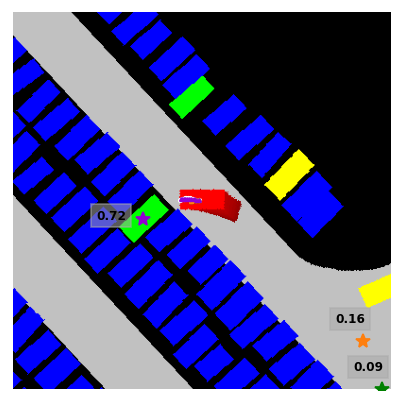

In [111]:
colors = ['darkviolet', 'C1', 'green']
intent_offsets = [[-50, 0], [-30, -20], [-30, -20]]

draw_prediction(multimodal_prediction, inst_centric_view,
                colors, intent_offsets)
